In [1]:
from importlib import reload
import re
import km_constant as kc
import km_utils as ku
import os
from typing import List, Dict
import itertools
import time

reload(kc)
reload(ku)

<module 'km_utils' from 'd:\\FYP\\KMWS\\km_utils.py'>

# 1. Sentence Tokenize

In [2]:
def sent_tokenize(text: str) -> List[str]:
    return [
        sent.strip() for sent in re.split(f"[{''.join(kc.KM_SENT_SEPARATOR)}]", text) if len(sent) > 0
    ]


def block_tokenize(text: str) -> List[str]:
    return [
        sent.replace('-', ' ').strip() for sent in re.split(f"[{''.join(kc.KM_SEPARATOR)}\[\]\(\)]", text) if len(sent.strip()) > 0
    ]

def part_tokenize(text: str) -> List[str]:
    temp = [word.replace(',', '').strip() for word in ku.flatten(ku.get_km_only(block_tokenize(text)))]
    return [word.strip() for word in temp if len(word.strip()) > 0]

# 2. Prepare Dictionary

In [3]:
with open('./unique-root.txt', 'r', encoding='utf-8') as f:
    dictionary: List[str] = f.read().split('\n')
f.close()

In [4]:
with open('./filtered-countries-km.txt', 'r', encoding='utf-8') as f:
    countries: List[str] = f.read().split('\n')
f.close()

In [5]:
with open('./km-district.txt', 'r', encoding='utf-8') as f:
    districts: List[str] = f.read().split('\n')
f.close()

In [6]:
with open('./cities-km.txt', 'r', encoding='utf-8') as f:
    cities: List[str] = f.read().split('\n')
f.close()

In [7]:
with open('./months-km.txt', 'r', encoding='utf-8') as f:
    months: List[str] = f.read().split('\n')
f.close()

In [8]:
with open('./common-words.txt', 'r', encoding='utf-8') as f:
    commons: List[str] = f.read().split('\n')
f.close()

In [9]:
local_dict: List[str] = [word.strip() for word in (dictionary + countries + districts + cities + months + commons) if len(word) > 0]

In [10]:
MAX_LEN: int = max([len(word) for word in local_dict])

In [11]:
ALL_LEN: int = set([len(word) for word in local_dict])

In [12]:
dicts: Dict[int, str] = {k: [word for word in local_dict if len(word) == k] for k in ALL_LEN}

# 3. Help Function

In [13]:
def get_kcc(word: str) -> List[str]:
    tokens: List[str] = []
    idx: List[int] = []
    find_number: bool = False
    for (i, c) in enumerate(word):
        if c in kc.ENGU_CONSONANT | kc.ENGL_CONSONANT:
          return [word]
        if c in kc.KM_NUMBER | kc.EN_NUMBER and not find_number:
            find_number = True
            idx.append(i)
        if c in kc.KM_CONSONANT | kc.KM_INDEP_VOWEL:
            find_number = False
            if i == 0:
                idx.append(i)
            if (i > 0 and word[i-1] not in kc.KM_SUB):
                idx.append(i)
    for i,j in zip(idx, [*idx[1:], len(word)]):
        tokens.append(word[i:j])
    return tokens

In [14]:
def has_vowel(word: str, vowels: set = kc.KM_DEP_VOWEL | kc.KM_INDEP_VOWEL) -> bool:
    return any(v in word for v in vowels)

In [15]:
def part_in_dict(word: str) -> bool:
    for w in local_dict:
        if word in w: 
        # or word.replace('្ត', '្ដ') in w or word.replace('្ដ', '្ត') in w:
            return True
    return False

In [16]:
def in_dict(word: str) -> bool:
    return word in local_dict 
# or word.replace('្ត', '្ដ') in local_dict or word.replace('្ដ','្ត') in local_dict

In [18]:
# EXCEPTIONS = ['គ្រូ', 'ពី', 'ជា', 'ស្រី', 'ថា', 'ខ្សែ', 'រី', 'បី', 'កែ', 'ហា', 'ឡា', 'ទី', 'ន្យា', 'ម្រើ', 'នា', 'ត្តា', 'កែ', 'ខែ', 'ក្សា', 'ទេ', 'តែ', 'លា', 'ពៃ', 'ណើ', 'ដៃ', 'វី', 'ហា', 'ន្ត', 'ណ្តា', 'ក្សា', 'ជី', 'សា']

In [19]:
# def get_syllables(sent: str) -> List[str]:
#     parts = part_tokenize(sent)
#     kccs = ku.flatten(get_kcc(part) for part in parts)
#     i: int = 0
#     tokens: List[str] = []
#     while i < len(kccs):
#         # check if not EOL
#         # print(kccs[i], end=' ')
#         if i < (len(kccs) - 1):
#             # print(12)
#             if kccs[i] == 'ជា' and kccs[i+1] == 'តិ':
#                 # print(1)
#                 tokens.append(kccs[i] + kccs[i+1])
#                 i += 2
#                 continue
#             if kccs[i] in EXCEPTIONS:
#                 # print(2)
#                 tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if kccs[i][0] in kc.KM_NUMBER | kc.EN_NUMBER:
#                 # print(3)
#                 tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if kccs[i] in kc.KM_INDEP_VOWEL:
#                 # print(4)
#                 tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if  kccs[i] in ['ត្ត', 'ត្តិ', 'គ្គ', 'ស្ស', 'ហ្វ']:
#                 # print(5)
#                 if len(tokens) > 0 and part_in_dict(tokens[-1] + kccs[i]):
#                     tokens[-1] = tokens[-1] + kccs[i]
#                 else:
#                     tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if '្ធ' in kccs[i]:
#                 # print(6)
#                 if len(tokens) > 0 and has_vowel(tokens[-1], ['ិ','ី','ឹ','ឺ','ុ']) and len(kccs[i]) == 3 and part_in_dict(tokens[-1] + kccs[i]):
#                     # print(7)
#                     tokens[-1] = tokens[-1] + kccs[i]
#                 else:
#                     # print(8)
#                     tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if '៏' in kccs[i]:
#                 # print(9)
#                 tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if '៍' in kccs[i]:
#                 # print(10)
#                 if len(tokens) > 0 and part_in_dict(tokens[-1] + kccs[i]):
#                     tokens[-1] = tokens[-1] + kccs[i]
#                 else:
#                     tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if has_vowel(kccs[i], ['ាំ']):
#                 # print(17)
#                 if kccs[i+1] == 'ង' and part_in_dict(kccs[i] + kccs[i+1]):
#                     # print(18)
#                     tokens.append(kccs[i] + kccs[i+1])
#                     i += 2
#                 else:
#                     # print(19)
#                     tokens.append(kccs[i])
#                     i += 1
#                 continue
#             if has_vowel(kccs[i], ['ះ', 'ៅ', 'ុំ', 'ំ', 'ៈ']):
#                 # print(11)
#                 tokens.append(kccs[i])
#                 i += 1
#                 continue
#             if kccs[i] == 'រ' and '៍' in kccs[i+1] and part_in_dict(kccs[i] + kccs[i+1]):
#                 # print(13)
#                 tokens.append(kccs[i] + kccs[i+1])
#                 i += 2
#                 continue
#             if '័' in kccs[i]:
#                 # print(14)
#                 if i+2 < len(kccs) and '៍' in kccs[i+2] and part_in_dict(kccs[i] + kccs[i+1] + kccs[i+2]):
#                     # print(15)
#                     tokens.append(kccs[i] + kccs[i+1] + kccs[i+2])
#                     i += 3 
#                 elif part_in_dict(kccs[i] + kccs[i+1]):
#                     # print(16)
#                     tokens.append(kccs[i] + kccs[i+1])
#                     i += 2 
#                 else:
#                     tokens.append(kccs[i])
#                     i += 1
#                 continue
#             if '់' in kccs[i+1]:
#                 if kccs[i] + kccs[i+1] == 'បស់' and len(tokens) > 0 and 'រ' in tokens[-1][-1]:
#                     tokens[-1] = tokens[-1][:len(tokens[-1]) - 1]
#                     tokens.append('រ' + kccs[i] + kccs[i+1])
#                 else:
#                     tokens.append(kccs[i] + kccs[i+1])
#                 i += 2
#                 continue
#             #
#             if len(kccs[i+1]) == 1 and has_vowel(kccs[i]) and kccs[i+1] in ['ក','គ','ង','ច','ញ','ត','ទ','ធ','ន','ប','ព','ម','យ','រ','ល','វ','ស'] and part_in_dict(kccs[i] + kccs[i+1]) and not (i+2 <len(kccs) and kccs[i+1] == 'រ' and '៍' in kccs[i+2]): 
#                 # print(21)
#                 if i+2 < len(kccs) - 1:
#                     # print(22)
#                     if kccs[i+1] + kccs[i+2] == 'ករ':
#                         # print(23)
#                         tokens.append(kccs[i])
#                         i += 1
#                         continue
#                         # tokens.append(kccs[i+1] + kccs[i+2])
#                         # i+=3
#                     elif kccs[i+2] == 'ម្ពុ':
#                         # print(24)
#                         tokens.append(kccs[i])
#                         i+=1
#                         continue
#                 if part_in_dict(kccs[i] + kccs[i+1]):
#                     # print(25)
#                     tokens.append(kccs[i] + kccs[i+1])
#                     i+=2
#                 else:
#                     # print(26)
#                     tokens.append(kccs[i])
#                     i+=1
#                 continue
#             else:
#                 # print(27)
#                 # print(22)
#                 tokens.append(kccs[i])
#                 i += 1
#         else: 
#             # print(23)
#             tokens.append(kccs[i])
#             i += 1
    
#     return [token for token in tokens if len(token) > 0]

In [17]:
def get_syllables(sent: str) -> List[str]:
    parts = part_tokenize(sent)
    kccs = ku.flatten(get_kcc(part) for part in parts)
    i: int = 0
    tokens: List[str] = []
    while i < len(kccs):
        if i < (len(kccs) - 1):
            in_dict_1 = len(tokens) > 0 and part_in_dict(tokens[-1] + kccs[i])
            in_dict_2 = part_in_dict(kccs[i] + kccs[i+1])
            if kccs[i] == 'ជា' and kccs[i+1] == 'តិ':
                tokens.append(kccs[i] + kccs[i+1])
                i += 2
            # elif kccs[i] in EXCEPTIONS:
            #     tokens.append(kccs[i])
            #     i += 1
            elif kccs[i][0] in kc.KM_NUMBER | kc.EN_NUMBER:
                tokens.append(kccs[i])
                i += 1
            elif kccs[i] in kc.KM_INDEP_VOWEL:
                tokens.append(kccs[i])
                i += 1
            elif  kccs[i] in ['ត្ត', 'ត្តិ', 'គ្គ', 'ស្ស', 'ហ្វ']:
                if in_dict_1:
                    tokens[-1] = tokens[-1] + kccs[i]
                else:
                    tokens.append(kccs[i])
                i += 1
            elif '្ធ' in kccs[i]:
                if has_vowel(tokens[-1], ['ិ','ី','ឹ','ឺ','ុ']) and len(kccs[i]) == 3 and in_dict_1:
                    tokens[-1] = tokens[-1] + kccs[i]
                else:
                    tokens.append(kccs[i])
                i += 1
            elif '៏' in kccs[i]:
                tokens.append(kccs[i])
                i += 1
            elif '៍' in kccs[i]:
                if in_dict_1:
                    tokens[-1] = tokens[-1] + kccs[i]
                else:
                    tokens.append(kccs[i])
                i += 1
            elif has_vowel(kccs[i], ['ាំ']):
                if kccs[i+1] == 'ង' and in_dict_2:
                    tokens.append(kccs[i] + kccs[i+1])
                    i += 2
                else:
                    tokens.append(kccs[i])
                    i += 1
            elif has_vowel(kccs[i], ['ះ', 'ៅ', 'ុំ', 'ំ', 'ៈ']):
                tokens.append(kccs[i])
                i += 1
            elif kccs[i] == 'រ' and '៍' in kccs[i+1] and in_dict_2:
                tokens.append(kccs[i] + kccs[i+1])
                i += 2
            elif '័' in kccs[i]:
                if i+2 < len(kccs) and '៍' in kccs[i+2] and part_in_dict(kccs[i] + kccs[i+1] + kccs[i+2]):
                    tokens.append(kccs[i] + kccs[i+1] + kccs[i+2])
                    i += 3 
                elif in_dict_2:
                    tokens.append(kccs[i] + kccs[i+1])
                    i += 2 
                else:
                    tokens.append(kccs[i])
                    i += 1
            elif '់' in kccs[i+1]:
                if kccs[i] + kccs[i+1] == 'បស់' and len(tokens) > 0 and 'រ' in tokens[-1][-1]:
                    tokens[-1] = tokens[-1][:len(tokens[-1]) - 1]
                    tokens.append('រ' + kccs[i] + kccs[i+1])
                else:
                    tokens.append(kccs[i] + kccs[i+1])
                i += 2
            elif len(kccs[i+1]) == 1 and has_vowel(kccs[i]) and kccs[i+1] in ['ក','គ','ង','ច','ញ','ត','ទ','ធ','ន','ប','ព','ម','យ','រ','ល','វ','ស'] and in_dict_2 and not (i+2 <len(kccs) and kccs[i+1] == 'រ' and '៍' in kccs[i+2]): 
                if i+2 < len(kccs) - 1:
                    if kccs[i+1] + kccs[i+2] == 'ករ':
                        tokens.append(kccs[i])
                        i += 1
                        continue
                    elif kccs[i+2] == 'ម្ពុ':
                        tokens.append(kccs[i])
                        i+=1
                        continue
                if in_dict_2:
                    tokens.append(kccs[i] + kccs[i+1])
                    i+=2
                else:
                    tokens.append(kccs[i])
                    i+=1
            else:
                tokens.append(kccs[i])
                i += 1
        else: 
            tokens.append(kccs[i])
            i += 1
    
    return [token for token in tokens if len(token) > 0]

# 4. Look-up


In [18]:
def FMM(syllables: List[str]) -> List[str]:
    tokens: List[str] = []
    i: int = 0
    word: str = ''
    while i < len(syllables):
        if syllables[i] in kc.KM_NUMBER | kc.EN_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
            tokens.append(syllables[i])
            i += 1 
            continue 
        temp: List[str] = []
        idx: int = 0
        biggest_i: int = 0
        while len(word) <= MAX_LEN and i+idx < len(syllables):
            if syllables[i+idx][0] in kc.KM_NUMBER | kc.EN_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
                break
            word += syllables[i+idx]
            if not part_in_dict(word):
                # print(part_in_dict(word))
                break
            if len(word) in ALL_LEN and in_dict(word):
                temp.append(word)
                biggest_i = idx + 1
            idx += 1
        if len(temp) > 0:
            tokens.append(max(temp, key=len))
            i += biggest_i
        else:
            tokens.append(syllables[i])
            i += 1
        word = ''
    return tokens

In [19]:
def BMM(syl: List[str]) -> List[str]:
    tokens: List[str] = []
    i: int = 0
    word: str = ''
    syllables = syl[::-1]
    
    while i < len(syllables):
        if syllables[i] in kc.KM_NUMBER | kc.EN_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
            tokens.append(syllables[i])
            i += 1 
            continue 
        temp: List[str] = []
        idx: int = 0
        biggest_i: int = 0
        while len(word) <= MAX_LEN and i+idx < len(syllables):
            if syllables[i+idx][0] in kc.KM_NUMBER | kc.EN_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
                break
            word = syllables[i+idx] + word
            if not part_in_dict(word):
                # print(part_in_dict(word))
                break
            if len(word) in ALL_LEN and in_dict(word):
                temp.append(word)
                biggest_i = idx + 1
            idx += 1
        if len(temp) > 0:
            # print(temp)
            tokens.append(max(temp, key=len))
            i += biggest_i
        else:
            tokens.append(syllables[i])
            i += 1
        word = ''
    return tokens[::-1]

In [20]:
def count(words: List[str]):
    return sum([in_dict(word) for word in words])

In [21]:
def MM(syllables: List[str]):
    f = FMM(syllables)
    b = BMM(syllables)
    return f if count(f) >= count(b) else b

# 5. Test

In [25]:
with open('./legit-file-names.txt', 'r') as f:
    LEGIT_FILE_NAMES = f.read().split('\n')
f.close()

In [29]:
for filename in LEGIT_FILE_NAMES:
    with open(f'./Organized Data/Docs/{filename}', 'r') as f:
        text = f.read()
    f.close()

    sents = sent_tokenize(text)
    parts = ku.flatten([part_tokenize(sent) for sent in sents])

    kcc_start = time.time()
    kccs = ku.flatten([get_kcc(part) for part in parts])
    kcc_end = time.time()

    syl_start = time.time()
    syllables = ku.flatten([get_syllables(sent) for sent in sents])
    syl_end = time.time()

    kcc_token_start = time.time()
    kcc_tokens = MM(kccs)
    kcc_token_end = time.time()

    syl_token_start = time.time()
    syl_tokens = MM(syllables)
    syl_token_end = time.time()

    with open(f'./Syllable3/{filename}', 'w', encoding='utf-8') as f:
        f.write(' '.join(syllables))
    f.close()
    with open(f'./ResKCC3/{filename}', 'w', encoding='utf-8') as f:
        f.write(' '.join(kcc_tokens))
    f.close()
    with open(f'./ResSyl3/{filename}', 'w', encoding='utf-8') as f:
        f.write(' '.join(syl_tokens))
    f.close()
    with open(f'./Logs3/{filename}', 'w', encoding='utf-8') as f:
        f.write(f'sent: 0.0\n')
        f.write(f'syl: {syl_end - syl_start}\n')
        f.write(f'syl tokens: {syl_token_end - syl_token_start}\n')
        f.write(f'kcc: {kcc_end - kcc_start}\n')
        f.write(f'kcc toknes: {kcc_token_end - kcc_token_start}\n')
    f.close()

In [30]:
for filename in LEGIT_FILE_NAMES:
    with open(f'./ResSyl3/{filename}', 'r') as f:
        syl_tokens = f.read().split(' ')
    f.close()
    with open(f'./ResKCC3/{filename}', 'r') as f:
        kcc_tokens = f.read().split(' ')
    f.close()
    kcc_correct = 0
    kcc_incorrect = 0
    for token in kcc_tokens:
        if token[0] not in kc.EN_NUMBER | kc.KM_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
            if in_dict(token):
                kcc_correct += 1
            else:
                kcc_incorrect += 1

    syl_correct = 0
    syl_incorrect = 0
    for token in syl_tokens:
        if token[0] not in kc.EN_NUMBER | kc.KM_NUMBER | kc.ENGL_CONSONANT | kc.ENGU_CONSONANT:
            if in_dict(token):
                syl_correct += 1
            else:
                syl_incorrect += 1
                with open('error-words3.txt', 'a') as f:
                    f.write(f'{token} ')
                f.close()
    if (kcc_correct + kcc_incorrect) > 0 and (syl_correct + syl_incorrect) > 0:
        with open(f'Res3/{filename}', 'w') as f:
            f.write(f'{kcc_correct} {kcc_incorrect} {kcc_correct/(kcc_correct + kcc_incorrect)} {syl_correct} {syl_incorrect} {syl_correct / (syl_correct + syl_incorrect)}')
        f.close()

# 6. Plot

In [25]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('./legit-file-names.txt', 'r', encoding='utf-8') as f:
    LEGIT_FILE_NAMES = f.read().split('\n')
f.close()

In [11]:
# CHR_LENS = []
# for i, filename in enumerate(LEGIT_FILE_NAMES):
#     with open(f'./Organized Data/Docs/{filename}', 'r', encoding='utf-8') as f:
#         text = f.read()
#         sents = sent_tokenize(text)
#         parts = ku.flatten(part_tokenize(sent) for sent in sents)
#         CHR_LENS.append(str(len(''.join(parts))))
#     f.close()
# with open('./file-lens-3.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(CHR_LENS))
# f.close()
with open('./file-lens-3.txt', 'r') as f:
    CHR_LENS = [int(n) for n in f.read().split('\n')]
f.close()

In [7]:
syl, syl_tokens, kcc, kcc_tokens = [], [], [], []

In [8]:
for i, filename in enumerate(LEGIT_FILE_NAMES):
    with open(f'./Logs3/{filename}', 'r', encoding='utf-8') as f:
        tokens = f.read().split()
        syl.append(round(float(tokens[3]), 3))
        syl_tokens.append(round(float(tokens[6]), 3))
        kcc.append(round(float(tokens[8]), 3))
        kcc_tokens.append(round(float(tokens[11]), 3))
        # syl_time = tokens[3]
        # syl_token_time = tokens[6]
        # kcc_time = tokens[8]
        # kcc_token_time = tokens[11]
    f.close()

In [21]:
print(f'min char len: {np.min(CHR_LENS)} | max char len: {np.max(CHR_LENS)}')
print(f'average syllable computation: {np.average(syl)}')
print(f'average kcc computation: {np.average(kcc)}')
print(f'average diff between syllable and kcc computation: {np.average(np.array(syl) - np.array(kcc))}')
print(f'average syllable tokenization: {np.average(syl_tokens)}')
print(f'average kcc tokenization: {np.average(kcc_tokens)}')
print(f'average diff between kcc and syllable tokenization: {np.average(np.array(kcc_tokens) - np.array(syl_tokens))}')
print(f'average syllable computation + tokenization: {np.average(np.array(syl_tokens) + np.array(syl))}')
print(f'average kcc computation + tokenization: {np.average(np.array(kcc_tokens) + np.array(kcc))}')
print(f'average diff between syllable and kcc compuation + tokenization: {np.average((np.array(syl_tokens) + np.array(syl)) - (np.array(kcc_tokens) + np.array(kcc)))}')

min char len: 1 | max char len: 23933
average syllable computation: 0.24181301020408164
average kcc computation: 0.001829948979591837
average diff between syllable and kcc computation: 0.23998306122448979
average syllable tokenization: 0.4103095918367347
average kcc tokenization: 0.4848140306122449
average diff between kcc and syllable tokenization: 0.07450443877551022
average syllable computation + tokenization: 0.6521226020408164
average kcc computation + tokenization: 0.4866439795918367
average diff between syllable and kcc compuation + tokenization: 0.1654786224489796


In [22]:
syl_total = [i+j for i,j in zip(syl, syl_tokens)]
kcc_total = [i+j for i,j in zip(kcc, kcc_tokens)]

In [23]:
syl_correct = []
kcc_correct = []

for i, filename in enumerate(LEGIT_FILE_NAMES):
    with open(f'./Res3/{filename}', 'r', encoding='utf-8') as f:
        tokens = f.read().split()
        syl_correct.append(round(float(tokens[2]), 3))
        kcc_correct.append(round(float(tokens[5]), 3))
    f.close()

In [24]:
print(f'syl: {np.average(syl_correct)}')
print(f'kcc: {np.average(kcc_correct)}')

syl: 0.9575907142857142
kcc: 0.9426720408163267


In [31]:
LOWER = 0
UPPER = 100
data = pd.DataFrame({'syl': syl[LOWER:UPPER], 'syl_tokens': syl_tokens[LOWER:UPPER], 'syl_total': syl_total[LOWER:UPPER], 'syl_correct': syl_correct[LOWER:UPPER], 'kcc': kcc[LOWER:UPPER], 'kcc_tokens': kcc_tokens[LOWER:UPPER], 'kcc_total': kcc_total[LOWER:UPPER], 'kcc_correct': kcc_correct[LOWER:UPPER], 'chr_len': CHR_LENS[LOWER:UPPER]})

<Axes: xlabel='chr_len', ylabel='syl'>

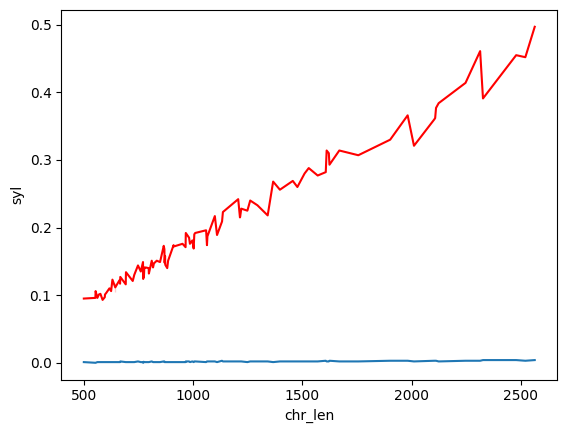

In [40]:
sns.lineplot(data=data, x='chr_len', y='syl', color='r')
sns.lineplot(data=data, x='chr_len', y='kcc')

<Axes: xlabel='chr_len', ylabel='syl_tokens'>

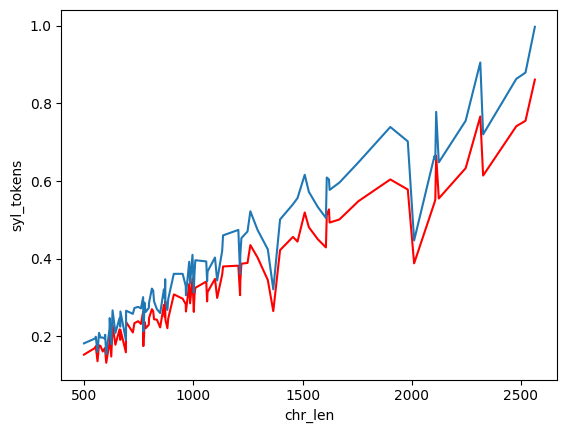

In [41]:
sns.lineplot(data=data, x='chr_len', y='syl_tokens', color='r')
sns.lineplot(data=data, x='chr_len', y='kcc_tokens')

<Axes: xlabel='chr_len', ylabel='syl_total'>

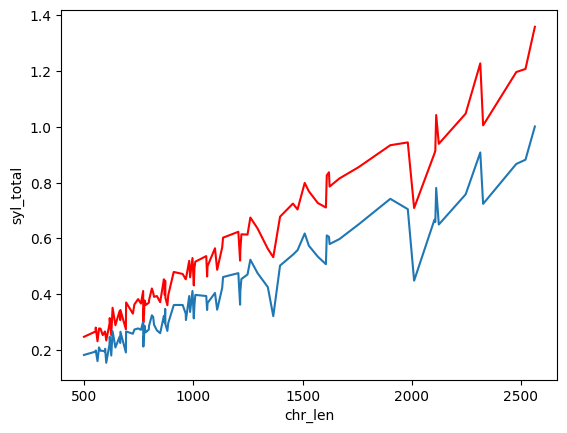

In [42]:
sns.lineplot(data=data, x='chr_len', y='syl_total', color='r')
sns.lineplot(data=data, x='chr_len', y='kcc_total')

Text(0, 0.5, 'accuracy')

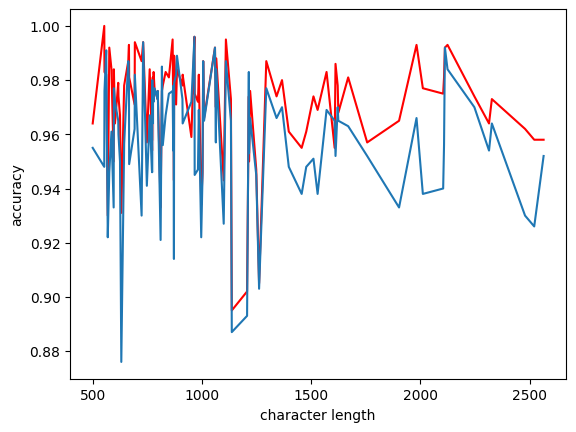

In [33]:
sns.lineplot(data=data, x='chr_len', y='syl_correct', color='r')
sns.lineplot(data=data, x='chr_len', y='kcc_correct')
plt.title('Comparison')
plt.xlabel('character length')
plt.ylabel('accuracy')